# Data Access Tutorial

This tutorial will show the basics of finding, downloading, and loading data using the LIGO/Virgo Open Science Center web site

## Find an O1 data file

Start by trying to find an O1 data file.

1. Start at losc.ligo.org/data
1. Under "O1 data release", click the icon for "Data" (https://losc.ligo.org/archive/O1/)
1. Select the H1 detector, and click "continue"
1. Find the URL for the H1 data that starts at time 1126076416
1. Click the link for HDF5 to download the file

#### Check Questions:

1. Copy and paste URL for H1 data starting with time 1126076416:

## Find an O1 data quality segment list

1. You can read about O1 data quality segments at https://losc.ligo.org/O1/
1. Notice the difference between CAT 1 and CAT 2 segment lists
1. Navigate to the Timeline Query Form at https://losc.ligo.org/timeline/query/O1/
1. Select a segment list for H1, CBC CAT 2
1. You can see how to read a segment list here: https://losc.ligo.org/segments/

#### Check Questions:

1. Explain the difference between CAT 1 and CAT 2 segment lists:
1. How long is the first segment of O1, H1 data that passes CAT 2?

## Import some useful python modules

In [1]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import sys

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

pyversion = sys.version_info.major
if pyversion == 2: 
    import urllib2
else:
    import urllib.request

# -- Handy function to download data file, and return the filename
def download(url):
    filename = url.split('/')[-1]
    print('Downloading ' + url )
    if pyversion == 2: 
        r = urllib2.urlopen(url).read()
        f = open(filename, 'w')   # write it to the right filename
        f.write(r)
        f.close()
    else:
        urllib.request.urlretrieve(url, filename)  
    print("File download complete")
    return filename

## Download an HDF5 data file

In [2]:
# -- Use the URL for a data file you found above
url = 'https://losc.ligo.org/archive/data/O1/1125122048/H-H1_LOSC_4_V1-1126076416-4096.hdf5'
filename = url.split('/')[-1]
download(url)

File download complete


'H-H1_LOSC_4_V1-1126076416-4096.hdf5'

## Plot a short time series

In the code below:
1. Use the `readligo.loaddata()` method to load a time vector and strain vector from the data file
 1. *Hint: See how to use the `loaddata()` method here: https://losc.ligo.org/tutorial04/*
1. Plot strain as a function of time for 1000 samples 
 1. *Hint: Example code at bottom of https://losc.ligo.org/tutorial02/*

File download complete


Text(0,0.5,u'H1 Strain')

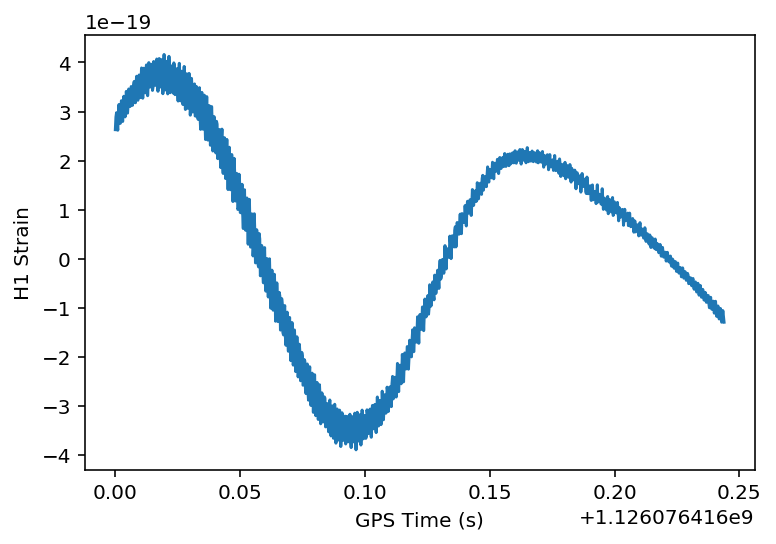

In [3]:
download('https://losc.ligo.org/s/sample_code/readligo.py')
import readligo as rl

# -- Use the loaddata() method here to load strain data
strain, time, dq = rl.loaddata(filename, 'H1')

# -- Plot the first 1000 samples of strain vs. time here
numSamples = 1000
plt.plot(time[0:numSamples], strain[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')

## Make a PSD

LIGO data has noise that is strongly frequency dependent.  

1. Use the space below to make a PSD of 128 seconds of LIGO data
 1. Hint: See examples: https://losc.ligo.org/plot_gallery/

Text(0.5,0,u'Freq (Hz)')

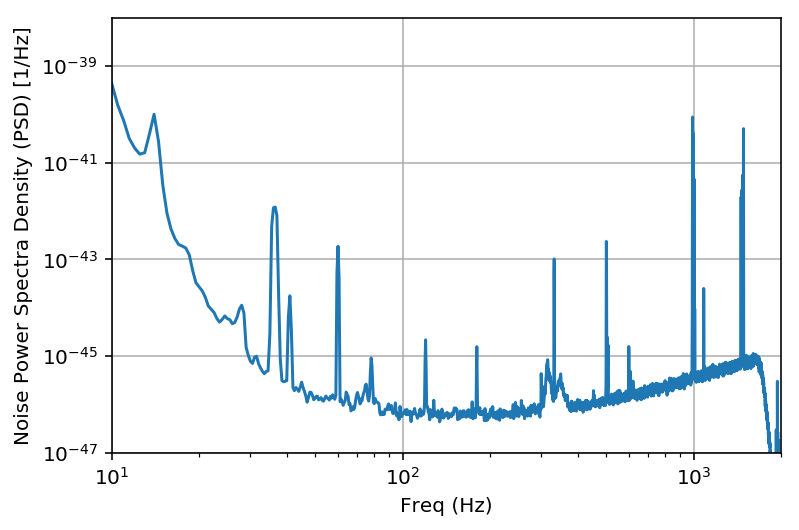

In [4]:
#-- Plot a PSD with 128 seconds of data 
ts = time[1] - time[0]      #-- Time between samples
fs = int(1.0 / ts)          #-- Sampling frequency
length = 128                #-- Number of seconds

strain_seg = strain[0:(length*fs)]
time_seg = time[0:(length*fs)]

Pxx, freqs = mlab.psd(strain_seg, Fs=fs, NFFT=2*fs)
plt.loglog(freqs, Pxx)
plt.axis([10, 2000, 1e-47, 1e-38])
plt.grid('on')
plt.ylabel('Noise Power Spectra Density (PSD) [1/Hz]')
plt.xlabel('Freq (Hz)')

#### Check Questions

1. What are the strongest line features in the PSD above?
 1. Hint: See notes on O1 spectral lines: https://losc.ligo.org/o1speclines/
1. What is the most sensitive frequency band for LIGO?
1. What is the ratio of noise power at 20 Hz compared with 100 Hz?
1. What are the main broad-band noise compentents at low-frequency (f<50 Hz) and high-frequency (f>300 Hz).


## Whiten GW150914

1. Download a data file that contains the data for GW150914
 1. Hint: GPS 1126259462.4
1. Whiten and band-pass the data
 1. Hint: See the Quickview tutorial: https://github.com/losc-tutorial/quickview/blob/master/index.ipynb
1. Plot the whitened, band-passed time series.  Can you see the signal?

File download complete


Text(0.5,1,u'WHITENED strain')

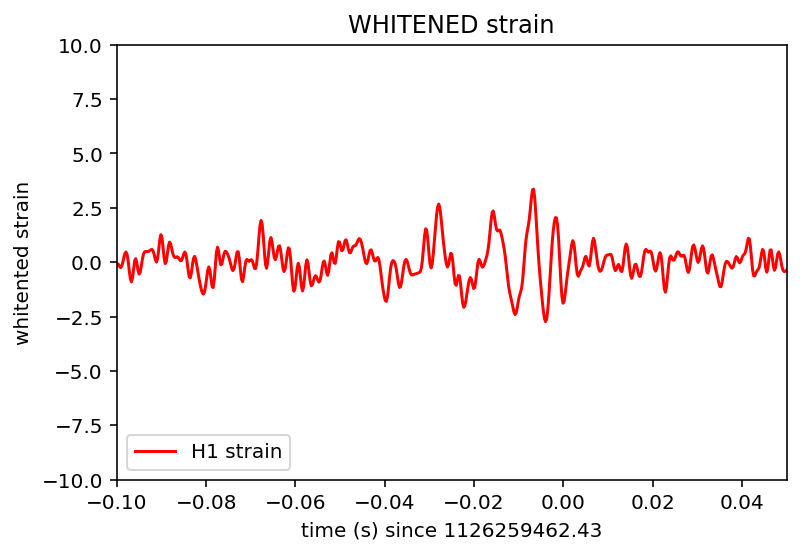

In [5]:
#-- Download a data file containing GW150914 
url = 'https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_4_V2-1126259446-32.hdf5'
fn_150914 = download(url)
strain, time, chan_dict_H1 = rl.loaddata(fn_150914, 'H1')

# the time sample interval (uniformly sampled!)
t0 = 1126259462.43
dt = time[1] - time[0]
fs = int(np.round(1/dt))
rel_time = time - t0

#-- How much data to use for the ASD?
deltat = 15  # Number of seconds on each side of data
N_samp = deltat*fs

# -- Center the PSD segment on the requested time
indx = np.where(np.abs(rel_time) < dt)[0][0]
strain_seg = strain[indx-N_samp : indx+N_samp]
time_seg = rel_time[indx-N_samp : indx+N_samp]

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000

# -- Calculate PSD
Pxx, freqs = mlab.psd(strain_seg, Fs = fs, NFFT=NFFT, 
                      noverlap=NFFT/2, window=np.blackman(NFFT))

# We will use interpolations of the ASDs computed above for whitening:
psd = interp1d(freqs, Pxx)

# -- Whiten
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data
strain_whiten = whiten(strain_seg,psd,dt)

# We need to suppress the high frequencies with some bandpassing:
high_freq = 600.
low_freq  = 30.
bb, ab = butter(4, [low_freq*2./fs, high_freq*2./fs], btype='band')
strain_whitenbp = filtfilt(bb, ab, strain_whiten)

#-- Plot the whitened time series
fig2 = plt.figure()
plt.plot(time_seg,strain_whitenbp,'r',label='H1 strain')

plt.xlim([-0.1,0.05])
plt.ylim([-10,10])
plt.xlabel('time (s) since '+str(t0))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('WHITENED strain')

## More to explore: Find and plot a loud O1 hardware injection

Hardware injections are simulated signals added to LIGO data.

1. Find the time of an O1, CBC hardware injection with SNR > 40
 1. Hint: See O1 hardware injection page: https://losc.ligo.org/o1_inj/
1. Download, whiten, band-pass, and plot the hardware injection, as above 

In [6]:
# -- Download a file containing a loud CBC hardware injection
# See https://losc.ligo.org/o1_inj/

# Whiten and band-pass data, as above
# Or, See example: https://github.com/losc-tutorial/quickview/blob/master/index.ipynb

# -- Plot the whitened time-series 